<a href="https://colab.research.google.com/github/gabrielbaltazarmw2/CAMUS-dataset/blob/main/UNET_CAMUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importação das bibliotecas

In [ ]:
# Standard
import os
import sys
import datetime
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
import tensorflow.keras.backend as K
from tensorflow import argmax
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

# Utils
import h5py

##Importando o dataset

In [ ]:
from google.colab import drive

# Monta o Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Caminho do arquivo original no Google Drive
caminho_original = '/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/image_dataset.hdf5'

#Preprocessamento

In [ ]:
f = h5py.File(caminho_original, "r")

In [ ]:
frames4ch = f["train 4ch frames"][:,:,:,:]
masks4ch = f["train 4ch masks"][:,:,:,:]

In [ ]:
train_frames, test_frames, train_masks, test_masks = train_test_split(frames4ch, masks4ch)

#Métricas

In [ ]:
def multiclass_dice(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))


def dice_lv(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:2])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,1:2])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_la(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,3:4])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,3:4])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

def dice_myo(y_true, y_pred, smooth=1e-7, num_classes=4):
    '''
    Multiclass Dice score. Ignores background pixel label 0
    Pass to model as metric during compile statement
    '''
    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,2:3])
    y_pred_f = K.flatten(K.one_hot(argmax(y_pred, axis=3), num_classes=4)[...,2:3])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return K.mean((2. * intersect / (denom + smooth)))

#Função de Perda

In [ ]:
def generalized_dice_loss(y_true, y_pred, smooth=1e-7, num_classes=4):

    y_true_f = K.flatten(K.one_hot(K.cast(y_true, 'int32'), num_classes=4)[...,1:])
    y_pred_f = K.flatten(y_pred[...,1:])
    intersect = K.sum(y_true_f * y_pred_f, axis=-1)
    denom = K.sum(y_true_f + y_pred_f, axis=-1)
    return 1.0-K.mean((2. * intersect / (denom + smooth)))

#Implementação da UNet

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

def conv2D_module(inputs, filters, kernel_size=3, padding="valid", pool_size=2):

    """
    CONV => RELU => CONV => RELU => MAXPOOL
    """

    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding,
               kernel_initializer='he_normal')(inputs)
    x = Activation("relu")(x)
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding=padding,
               kernel_initializer='he_normal')(inputs)
    x = Activation("relu")(x)


def UNet(input_size, depth, num_classes, filters, batch_norm):

    """
    UNet (Ronneberger, 2015) implementation in tensorflow.keras
    using Keras Functional API.
    """

    # Input layer
    inputs = Input(input_size)
    x = inputs

    # Encoding
    down_list = []
    for layer in range(depth):
        x = Conv2D(filters, 3, activation='relu', padding='same', kernel_initializer='he_normal')(x)

        if batch_norm:
            x = BatchNormalization()(x)
            x = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
            x_down = BatchNormalization()(x)
        else:
            x_down = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)

        down_list.append(x_down)
        x = MaxPooling2D(pool_size=2)(x_down)
        filters = filters*2

    # Bottom
    x = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    if batch_norm: x = BatchNormalization()(x)
    x = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
    if batch_norm: x = BatchNormalization()(x)

    # Decoding
    for layer in reversed(down_list):
        filters = filters // 2
        x = UpSampling2D((2,2))(x)
        x = concatenate([x, layer])
        x = Conv2D(filters, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(x)
        if batch_norm: x = BatchNormalization()(x)
        x = Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(x)
        if batch_norm: x = BatchNormalization()(x)

    # Output layer
    x = Conv2D(filters=num_classes, kernel_size=1)(x)
    if batch_norm: x = BatchNormalization()(x)
    outputs = Activation("softmax")(x)

    model = Model(inputs, outputs)
    return model

In [ ]:
# Parâmetros
input_size = (384, 384, 1)  # Tamanho de entrada
depth = 4  # Profundidade da rede
num_classes = 4  # Número de classes de saída
filters = 32  # Número inicial de filtros
batch_norm = True  # Usar batch normalization

# Criar modelo UNet
model = UNet(input_size, depth, num_classes, filters, batch_norm)

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=1e-3), loss="sparse_categorical_crossentropy", metrics=[multiclass_dice, "accuracy"])

# Resumo do modelo
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
def criar_diretorio(caminho):
  if not os.path.exists(caminho):
    os.makedirs(caminho)

In [ ]:
path_modelo = 'modelos'
criar_diretorio(path_modelo)

In [ ]:
earlystop = EarlyStopping(monitor='val_multiclass_dice', min_delta=0, patience=5,
                          verbose=1, mode="max", restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor='val_multiclass_dice', factor=0.2, patience=2,
                              verbose=1, mode="max", min_lr=1e-5)

callbacks = [ModelCheckpoint(path_modelo + '/modelo_drive_{epoch:02d}.h5', verbose=1, save_best_only=True),
             earlystop, reduce_lr]

In [ ]:
history = model.fit(x=train_frames,
                    y=train_masks,
                    validation_data=[test_frames, test_masks],
                    batch_size=5,
                    epochs=50,
                    callbacks=[earlystop, reduce_lr])

Epoch 1/50
135/135 [==============================] - 92s 423ms/step - loss: 0.7584 - multiclass_dice: 0.6993 - accuracy: 0.8772 - val_loss: 1.6769 - val_multiclass_dice: 0.5513 - val_accuracy: 0.8042 - lr: 0.0010
Epoch 2/50
135/135 [==============================] - 61s 451ms/step - loss: 0.5416 - multiclass_dice: 0.8200 - accuracy: 0.9363 - val_loss: 4.1170 - val_multiclass_dice: 0.3399 - val_accuracy: 0.3410 - lr: 0.0010
Epoch 3/50
135/135 [==============================] - 53s 397ms/step - loss: 0.4254 - multiclass_dice: 0.8539 - accuracy: 0.9489 - val_loss: 0.8691 - val_multiclass_dice: 0.6513 - val_accuracy: 0.8285 - lr: 0.0010
Epoch 4/50
135/135 [==============================] - 59s 437ms/step - loss: 0.3532 - multiclass_dice: 0.8630 - accuracy: 0.9526 - val_loss: 0.5509 - val_multiclass_dice: 0.7069 - val_accuracy: 0.8699 - lr: 0.0010
Epoch 5/50
135/135 [==============================] - 53s 396ms/step - loss: 0.3006 - multiclass_dice: 0.8712 - accuracy: 0.9552 - val_loss: 0.3

# Salvar e carregar o modelo

In [ ]:
model.save('/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/model_unet.h5')
print("Modelo salvo com sucesso!")

Modelo salvo com sucesso!


In [ ]:
from tensorflow.keras.models import load_model

# Caminho para o modelo no Google Drive
caminho_modelo = '/content/drive/MyDrive/Colab Notebooks/CAMUS DATASET/model_unet.h5'

# Load the model with the custom metric
custom_objects = {'multiclass_dice': multiclass_dice}
model_unet = load_model(caminho_modelo, custom_objects=custom_objects)

#Predição

1/1 [==============================] - 0s 195ms/step


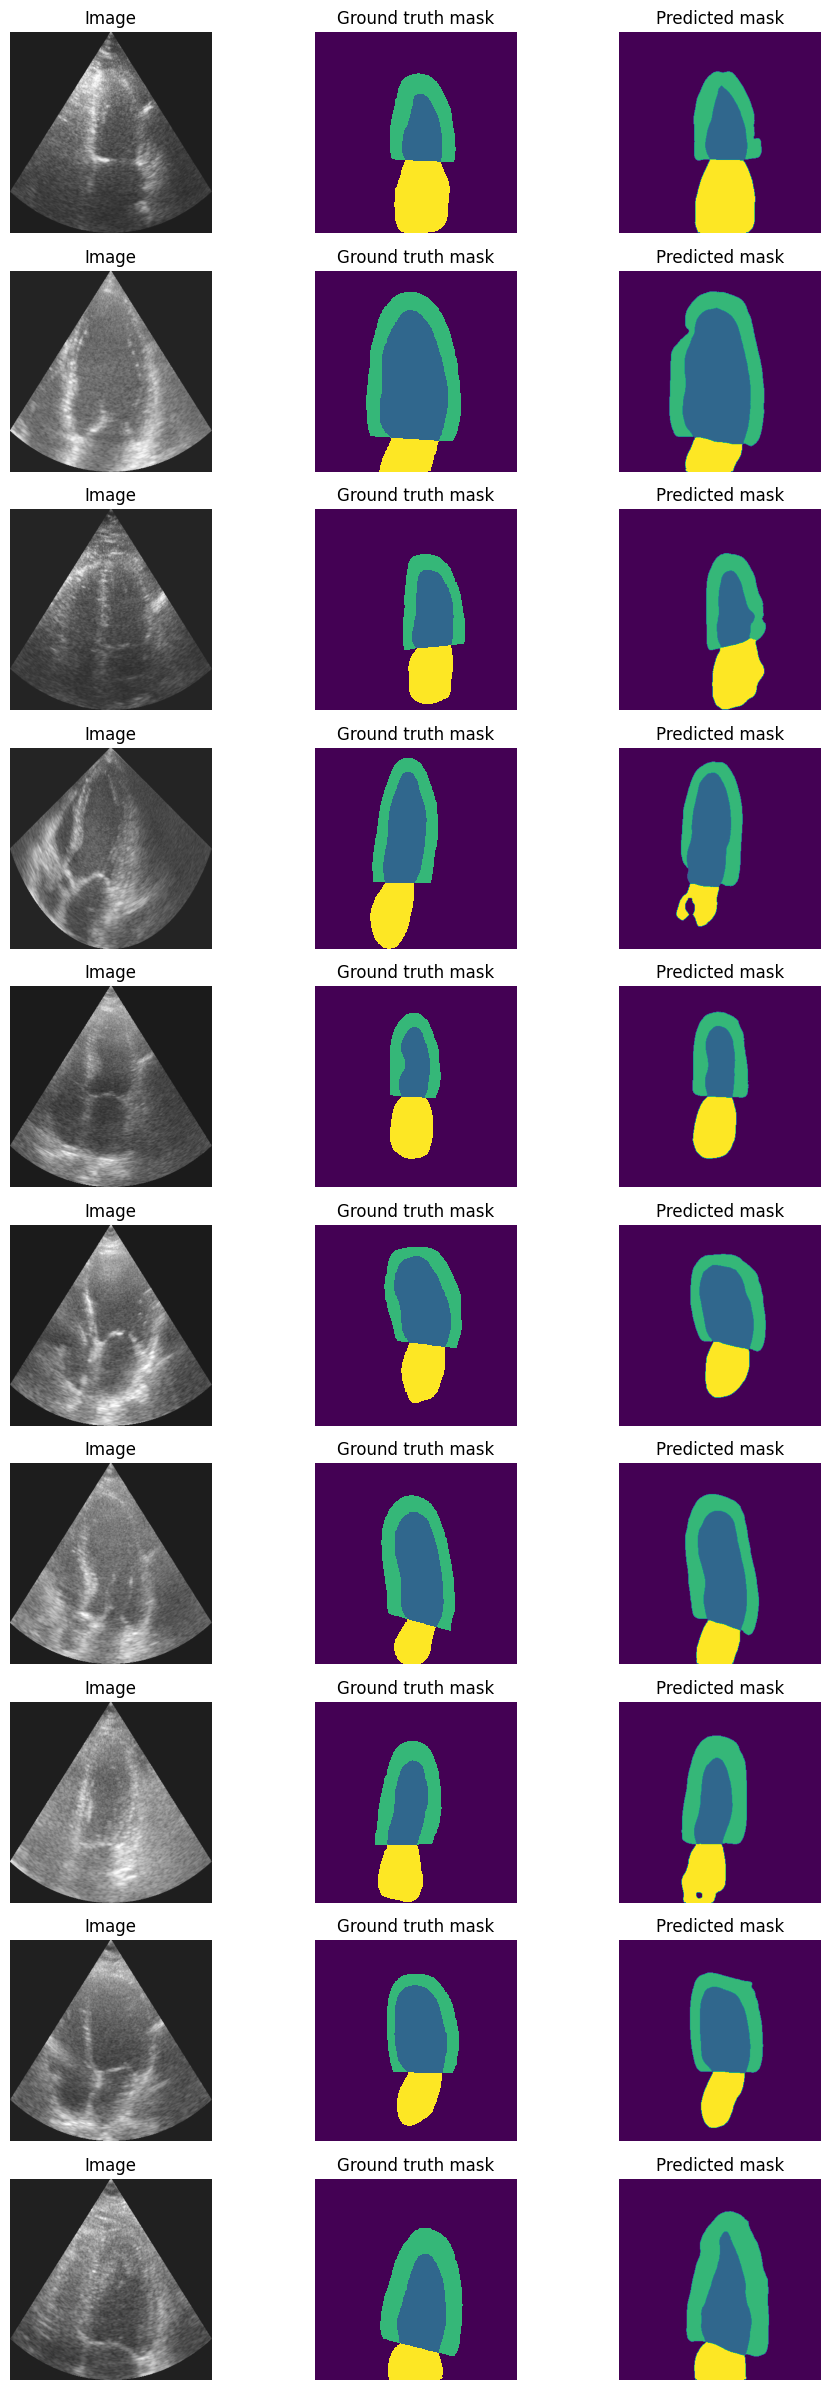

In [ ]:
def display_image_grid(test_frames, test_masks, predicted_masks=None):
    cols = 3 if predicted_masks else 2
    rows = 10
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(10, 24))
    for i in range(10):
        img = test_frames[i,:,:,0]
        mask = test_masks[i,:,:,0]

        ax[i, 0].imshow(img, cmap='gray')
        ax[i, 1].imshow(mask, interpolation="nearest")

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

        if predicted_masks:
            predicted_mask = predicted_masks[i]
            ax[i, 2].imshow(predicted_mask)
            ax[i, 2].set_title("Predicted mask")
            ax[i, 2].set_axis_off()
    plt.tight_layout()
    plt.show()


predicted_masks = []
for i in range(50):
    prediction = model_unet.predict(test_frames[i:i+1,:,:,:])
    prediction = prediction.reshape([384, 384, 4])
    y = tf.convert_to_tensor(prediction)
    predicted_masks.append(tf.math.argmax(prediction, axis = 2))

display_image_grid(test_frames, test_masks, predicted_masks=predicted_masks)

In [ ]:
predicted_masks = np.array(predicted_masks)
predicted_masks.shape

(50, 384, 384)

In [ ]:
pip install celluloid

In [ ]:
from celluloid import Camera
from IPython.display import HTML

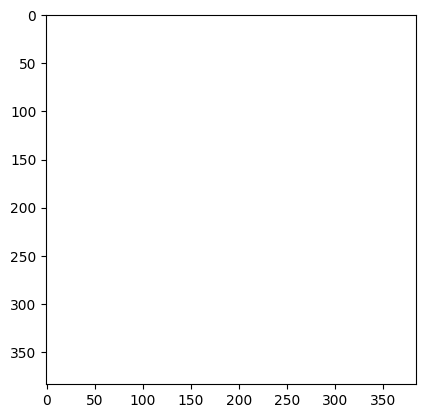

In [ ]:
fig = plt.figure()
camera = Camera(fig)  # Create the camera object from celluloid

for i in range(len(predicted_masks)):
    plt.imshow(test_frames[i,:,:], cmap="gray")
    plt.imshow(predicted_masks[i,:,:], alpha=0.3)
    camera.snap()  # Store the current slice
animation = camera.animate()  # Create the animation




In [ ]:
HTML(animation.to_html5_video())  # convert the animation to a video


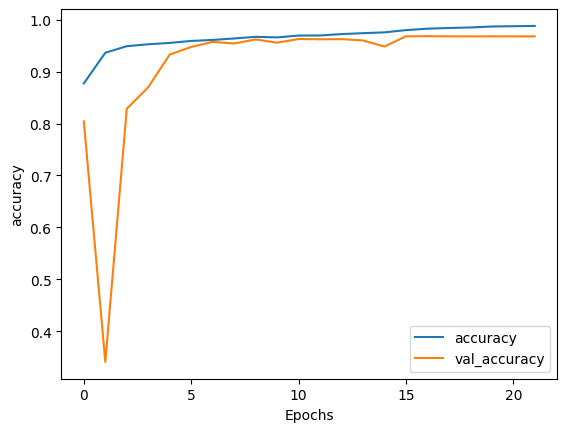

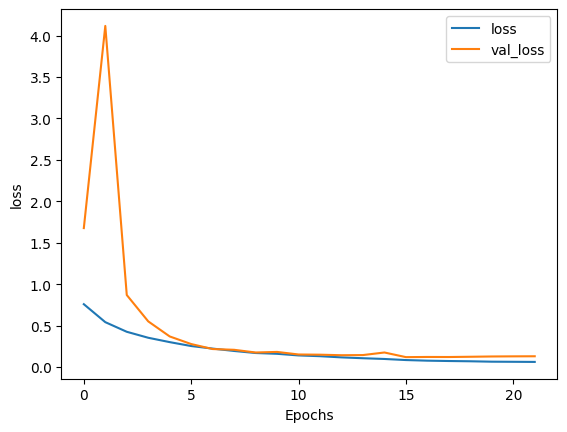

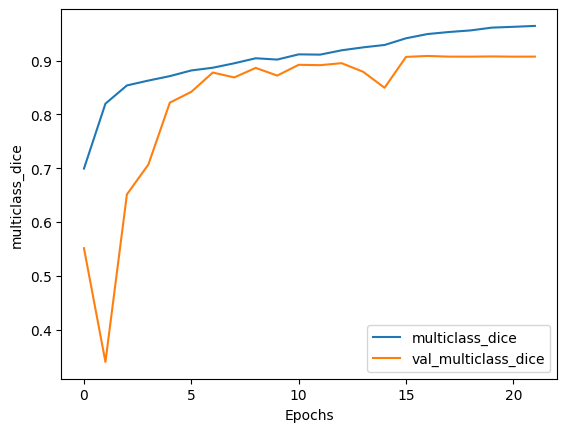

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")
plot_graphs(history, "multiclass_dice")